# **Stock Market Prediction using Numerical and Textual Analysis**

**This project aimed to analyze stock prices using historical data from the S&P 
BSE SENSEX index and news headlines. The news data was collected and preprocessed to extract sentiment information using text analysis techniques**

**The stock data was also collected and preprocessed, and an ARIMA model was used to make predictions on the stock prices.** 

**Both the news and stock data were then combined and used to train and test various machine learning models including LSTM, XGBoost, and Random Forest. The performance of these models was evaluated by comparing their mean squared error on the test data.**

**Ultimately, the LSTM model performed the best with the lowest mean squared error. The project demonstrates how incorporating sentiment analysis from news headlines can aid in the prediction of stock prices.** 

# **IMPORTING LIBRARIES**

In [139]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [38]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [48]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# **IMPORTING DATASETS**

**Importing news headline dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
df_news=pd.read_csv('/content/drive/MyDrive/The spark foundation/Data/india-news-headlines.csv')
df_news

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic
...,...,...,...
3650965,20220331,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650966,20220331,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650967,20220331,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650968,20220331,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


**Importing stock prices dataset**

In [108]:
# Collecting the data of Sensex from yahoo finance.
import time
import datetime

tickers = ['^BSESN']
interval = '1d'
start = int(time.mktime(datetime.datetime(1997, 1, 1).timetuple()))
end = int(time.mktime(datetime.datetime(2022, 3, 31).timetuple()))
for ticker in tickers:
   stock_query = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={start}&period2={end}&interval={interval}&events=history&includeAdjustedClose=true'
   df = pd.read_csv(stock_query)
   df.to_csv('stock.csv', index = None, header = True)

df_stock = pd.read_csv('stock.csv')
df_stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-07-01,4263.109863,4301.770020,4247.660156,4300.859863,4300.859863,0.0
1,1997-07-02,4302.959961,4395.310059,4295.399902,4333.899902,4333.899902,0.0
2,1997-07-03,4335.790039,4393.290039,4299.970215,4323.459961,4323.459961,0.0
3,1997-07-04,4332.700195,4347.589844,4300.580078,4323.819824,4323.819824,0.0
4,1997-07-07,4326.810059,4391.009766,4289.490234,4291.450195,4291.450195,0.0
...,...,...,...,...,...,...,...
6216,2022-03-24,57190.050781,57827.988281,57138.511719,57595.679688,57595.679688,51400.0
6217,2022-03-25,57801.718750,57845.371094,57100.238281,57362.199219,57362.199219,6900.0
6218,2022-03-28,57472.718750,57638.339844,56825.089844,57593.488281,57593.488281,6300.0
6219,2022-03-29,57814.761719,58001.531250,57639.351563,57943.648438,57943.648438,12100.0


# **Pre Processing News Data**

In [7]:
df_news.isnull().sum()

publish_date         0
headline_category    0
headline_text        0
dtype: int64

In [8]:
# drop duplicates from the dataframe
df_news.drop_duplicates(inplace=True)

# convert the 'publish_date' column to a datetime object
df_news['publish_date'] = pd.to_datetime(df_news['publish_date'], format='%Y%m%d')

# filter for the necessary columns
df_news = df_news[['publish_date', 'headline_text']]

# group the headlines by date, and join them into a single string
df_news = df_news.groupby('publish_date')['headline_text'].apply(', '.join).reset_index()

# set the 'publish_date' column as the index
df_news.set_index('publish_date', inplace=True)

# sort the dataframe by the index
df_news.sort_index(inplace=True)
df_news.head(10)

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark, Thin..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
2001-01-07,"Muslim body rules out talks on Ayodhya, Bajran..."
2001-01-08,"Sangh Parivar; Babri panel up the ante, Frontr..."
2001-01-09,Financier Bharat Shah held for alleged links w...
2001-01-10,"Fend for yourselves; Pande tells doctors, Bure..."


In [16]:
print(df_news.dtypes)

headline_text    object
dtype: object


In [14]:

# lowercase all the text in the headline_text column
df_news['headline_text'] = df_news['headline_text'].str.lower()

# remove any special characters or numbers from the headline_text column
df_news['headline_text'] = df_news['headline_text'].str.replace('[^a-zA-Z ]','')

# Create a set of stopwords
stop_words = set(stopwords.words('english'))

# Initialize the Snowball stemmer
stemmer = SnowballStemmer('english')

# Define a function to pre-process the text
def preprocess_text(text):
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in (stop_words)])
    # Tokenize the text
    tokens = word_tokenize(text)
    # Stem the remaining tokens
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    # Join the stemmed tokens back into a single string
    processed_text = ' '.join(stemmed_tokens)
    return processed_text

# Apply the pre-processing function to the headline_text column
df_news['headline_text'] = df_news['headline_text'].apply(preprocess_text)

<ipython-input-14-b71b0841f157>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_news['headline_text'] = df_news['headline_text'].str.replace('[^a-zA-Z ]','')


In [15]:
df_news


,headline_text
publish_date,
2001-01-02,status quo disturb ayodhya say vajpaye fissur ...
2001-01-03,powerless north india grope dark think laxman ...
2001-01-04,string pull stephen hawk india vajpaye give bi...
2001-01-05,light combat craft take india club class hawk ...
2001-01-06,light combat craft take india club class hawk ...
...,...
2022-03-27,play dead man bodi god meant sit refriger guru...
2022-03-28,fashion becom democrat demand stylist soar las...
2022-03-29,bobbi deol like dad hope work age yasha surya ...


# **Data Visualization News Data**

**I used wordcloud to identify the most common topics or themes in the news headlines.**

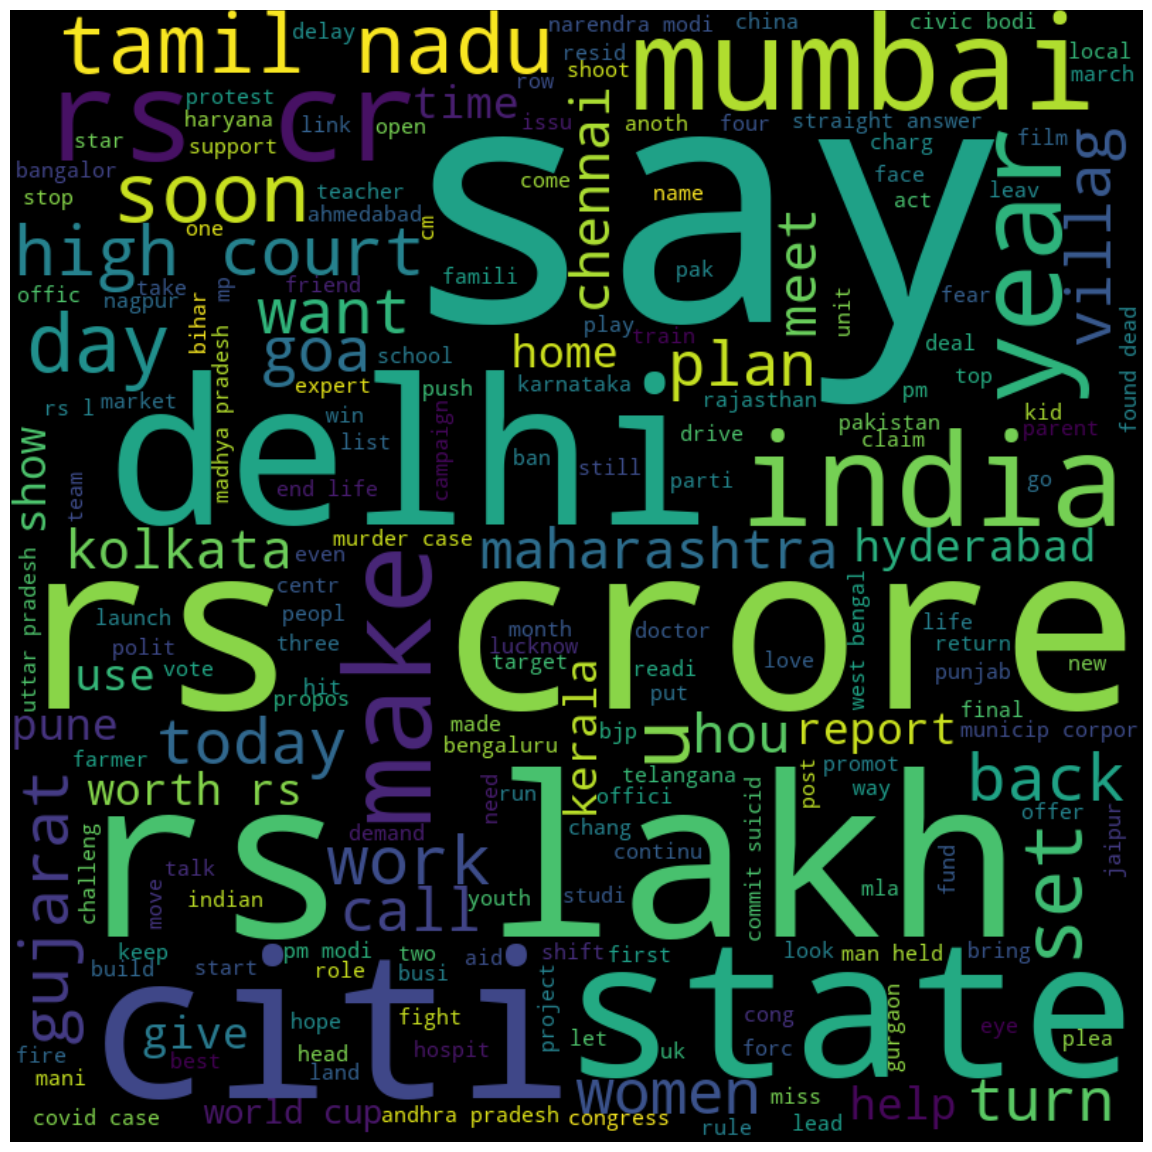

In [22]:
from wordcloud import WordCloud

# Create a string of all the headlines
headlines = ' '.join(df_news['headline_text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=800).generate(headlines)

# Display the word cloud
plt.figure(figsize=(15,15), dpi = 100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


**heatmap is a graphical representation of data where individual values are represented as colors. We can see here the distribution of news headlines over time**

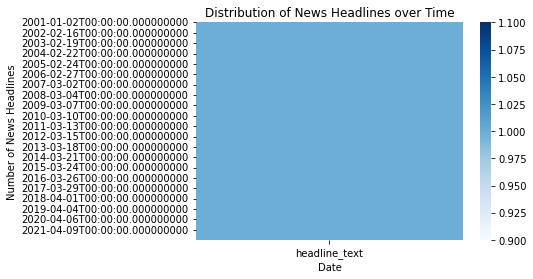

In [24]:
import seaborn as sns

# create a pivot table with the count of news headlines per day
pivot_table = df_news.pivot_table(index='publish_date', values='headline_text', aggfunc='count')

# create a heatmap of the pivot table
sns.heatmap(pivot_table, cmap='Blues')
plt.xlabel('Date')
plt.ylabel('Number of News Headlines')
plt.title('Distribution of News Headlines over Time')
plt.show()


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer()

# Fit and transform the data
tfidf_matrix = tfidf.fit_transform(df_news['headline_text'])

# Print the top 10 words by tf-idf score
print(tfidf.get_feature_names()[:10])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aa', 'aaa', 'aaaag', 'aaaah', 'aaadhar', 'aaaf', 'aaag', 'aaagaaz', 'aaai', 'aaaja']


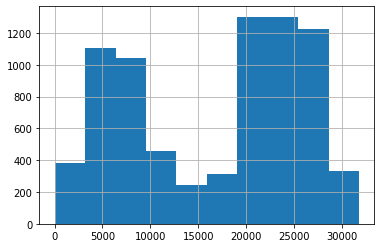

In [36]:
df_news['headline_text'].str.len().hist()
plt.show()

# **Sentiment Analysis of News Headline**

**Sentiment Lexicon-based Analysis: Sentiment lexicon-based analysis is a technique where we use a pre-built lexicon or dictionary of words and their corresponding sentiment scores to analyze the sentiment of our text data.**

In [43]:
from textblob import TextBlob
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [45]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['headline_text'].apply(getSubjectivity)
df_news['Polarity'] = df_news['headline_text'].apply(getPolarity)
df_news

,headline_text,Subjectivity,Polarity
publish_date,,,
2001-01-02,status quo disturb ayodhya say vajpaye fissur ...,0.307576,0.157576
2001-01-03,powerless north india grope dark think laxman ...,0.495833,0.058333
2001-01-04,string pull stephen hawk india vajpaye give bi...,0.482362,0.062947
2001-01-05,light combat craft take india club class hawk ...,0.440559,0.287937
2001-01-06,light combat craft take india club class hawk ...,0.410909,0.367273
...,...,...,...
2022-03-27,play dead man bodi god meant sit refriger guru...,0.366957,0.083142
2022-03-28,fashion becom democrat demand stylist soar las...,0.388229,0.077749
2022-03-29,bobbi deol like dad hope work age yasha surya ...,0.372428,0.092379


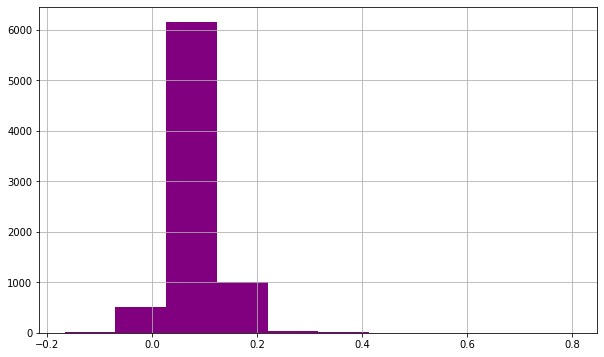

In [46]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

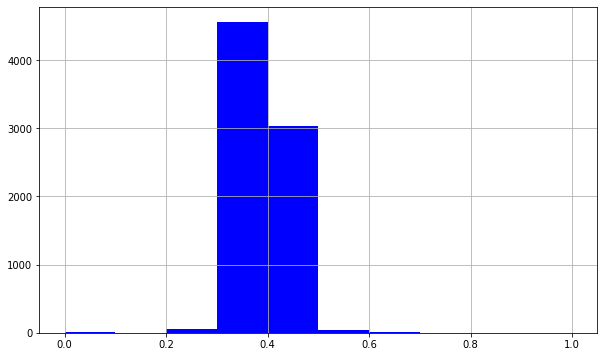

In [47]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

# **Adding sentiment score to df_news**

In [51]:

sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['headline_text']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['headline_text']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['headline_text']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['headline_text']]
df_news

,headline_text,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
publish_date,,,,,,,
2001-01-02,status quo disturb ayodhya say vajpaye fissur ...,0.307576,0.157576,-0.9601,0.159,0.749,0.093
2001-01-03,powerless north india grope dark think laxman ...,0.495833,0.058333,0.4019,0.099,0.784,0.117
2001-01-04,string pull stephen hawk india vajpaye give bi...,0.482362,0.062947,0.9538,0.092,0.787,0.121
2001-01-05,light combat craft take india club class hawk ...,0.440559,0.287937,0.7918,0.148,0.682,0.170
2001-01-06,light combat craft take india club class hawk ...,0.410909,0.367273,-0.3182,0.155,0.695,0.150
...,...,...,...,...,...,...,...
2022-03-27,play dead man bodi god meant sit refriger guru...,0.366957,0.083142,-0.9998,0.146,0.784,0.069
2022-03-28,fashion becom democrat demand stylist soar las...,0.388229,0.077749,-0.9998,0.146,0.776,0.078
2022-03-29,bobbi deol like dad hope work age yasha surya ...,0.372428,0.092379,-0.9996,0.125,0.802,0.073


# **Stock Prices**

In [109]:
df_stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-07-01,4263.109863,4301.770020,4247.660156,4300.859863,4300.859863,0.0
1,1997-07-02,4302.959961,4395.310059,4295.399902,4333.899902,4333.899902,0.0
2,1997-07-03,4335.790039,4393.290039,4299.970215,4323.459961,4323.459961,0.0
3,1997-07-04,4332.700195,4347.589844,4300.580078,4323.819824,4323.819824,0.0
4,1997-07-07,4326.810059,4391.009766,4289.490234,4291.450195,4291.450195,0.0
...,...,...,...,...,...,...,...
6216,2022-03-24,57190.050781,57827.988281,57138.511719,57595.679688,57595.679688,51400.0
6217,2022-03-25,57801.718750,57845.371094,57100.238281,57362.199219,57362.199219,6900.0
6218,2022-03-28,57472.718750,57638.339844,56825.089844,57593.488281,57593.488281,6300.0
6219,2022-03-29,57814.761719,58001.531250,57639.351563,57943.648438,57943.648438,12100.0


# **Pre Process Data Stock Data**

In [110]:
# drop duplicates from the dataframe
df_stock.drop_duplicates(inplace=True)

# convert the 'Date' column to a datetime object
df_stock['Date'] = pd.to_datetime(df_stock['Date'])

# set the 'Date' column as the index
df_stock.set_index('Date', inplace=True)

# sort the dataframe by the index
df_stock.sort_index(inplace=True)

# drop any rows with missing values
df_stock.dropna(inplace=True)


In [89]:
df_stock.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-24,57190.050781,57827.988281,57138.511719,57595.679688,57595.679688,51400.0
2022-03-25,57801.718750,57845.371094,57100.238281,57362.199219,57362.199219,6900.0
2022-03-28,57472.718750,57638.339844,56825.089844,57593.488281,57593.488281,6300.0
2022-03-29,57814.761719,58001.531250,57639.351563,57943.648438,57943.648438,12100.0
2022-03-30,58362.851563,58727.781250,58176.000000,58683.988281,58683.988281,6300.0


# **Data Visualization stock Data**

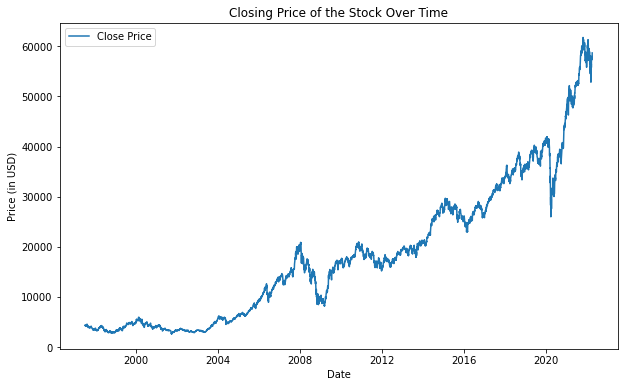

In [112]:
# plot the closing price of the stock over time
plt.figure(figsize=(10,6))
plt.plot(df_stock['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Price (in USD)')
plt.title('Closing Price of the Stock Over Time')
plt.legend()
plt.show()

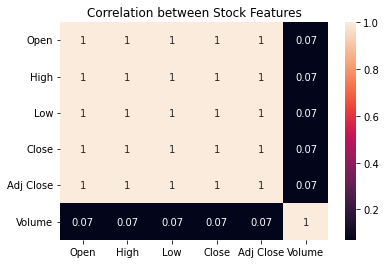

In [113]:
# plot a heatmap of the correlation between the different stock features
sns.heatmap(df_stock.corr(), annot=True)
plt.title('Correlation between Stock Features')
plt.show()

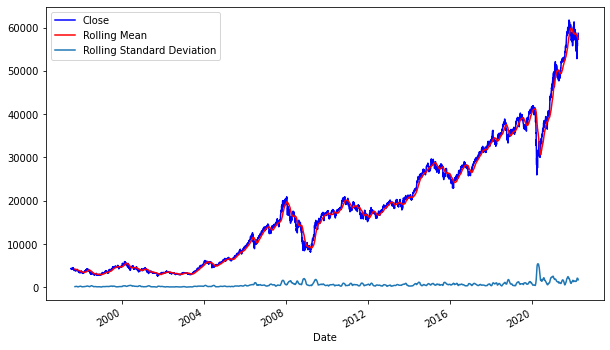

In [114]:
#Plotting moving average
close = df_stock['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_stock['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

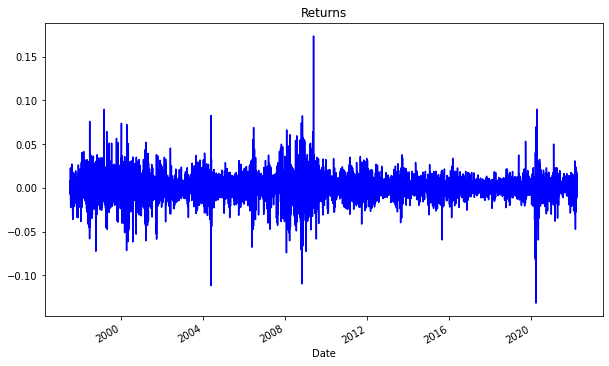

In [117]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'b')
plt.title("Returns")

In [101]:
df_stock.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-07-01,4263.109863,4301.770020,4247.660156,4300.859863,4300.859863,0.0
1997-07-02,4302.959961,4395.310059,4295.399902,4333.899902,4333.899902,0.0
1997-07-03,4335.790039,4393.290039,4299.970215,4323.459961,4323.459961,0.0
1997-07-04,4332.700195,4347.589844,4300.580078,4323.819824,4323.819824,0.0
1997-07-07,4326.810059,4391.009766,4289.490234,4291.450195,4291.450195,0.0


# **Stock Analysis**

Stationary test .. data is non stationary

In [118]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test on the 'Close' column
result = adfuller(df_stock['Close'])

# Print the test statistic and p-value
print('ADF test statistic:', result[0])
print('p-value:', result[1])


ADF test statistic: 1.5115640912588297
p-value: 0.9975664403517145


In [119]:
# Created a new column 'Close_rw' in the DataFrame with the rolling window transformed data
df_stock['Close_rw'] = (df_stock['Close'] - df_stock['Close'].rolling(window=12).mean()) / df_stock['Close'].rolling(window=12).std()

# Perform the ADF test on the rolling window transformed data
result = adfuller(df_stock['Close_rw'].dropna())

# Print the test statistic and p-value
print('ADF test statistic:', result[0])
print('p-value:', result[1])


ADF test statistic: -17.416228822178972
p-value: 4.85443220912121e-30


In [125]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 44.4 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [126]:
from pmdarima.arima import auto_arima

# Find the optimal values of p, d, and q
stepwise_fit = auto_arima(df_stock['Close_rw'].dropna(), start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           seasonal=True,
                           d=None, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

# Print the optimal values of p, d, and q
print("Optimal values of p, d, and q are: ", stepwise_fit.order)


arima = sm.tsa.ARIMA(df_stock['Close_rw'].dropna(), order=stepwise_fit.order)
arima_fit = arima.fit()

# Print a summary of the model
print(arima_fit.summary())

 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=12534.527, Time=11.80 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=19879.282, Time=0.23 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=12620.103, Time=7.65 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=15494.403, Time=10.87 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=20044.922, Time=0.14 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=12532.513, Time=8.27 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=12532.323, Time=2.59 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=12532.512, Time=6.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=15501.469, Time=2.50 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=12619.021, Time=1.35 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=12532.078, Time=5.87 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=12531.994, Time=14.55 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=12533.991, Time=25.56 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=12534.005, Time=11.56 sec


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency informa

In [136]:
# Make predictions for the next 10 days
predictions = arima_fit.forecast(steps=len(df_stock))[0]




# Print the predictions
print(predictions)


[1.46122243 1.20697055 0.99079907 ... 0.20670844 0.20670844 0.20670844]


In [140]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# calculate evaluation metrics
mae = mean_absolute_error(df_stock['Close'], predictions)
mse = mean_squared_error(df_stock['Close'], predictions)
rmse = np.sqrt(mse)

# print evaluation metrics
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)



MAE: 18349.62184164426
MSE: 535251406.0138922
RMSE: 23135.50098904046


# **Merging Data**

**renaming date**

In [144]:
df_news = df_news.rename_axis('Date', axis='index')


In [145]:
print(df_news.index.name)


Date


In [146]:
df_merge = pd.merge(df_stock, df_news, how='inner', on='Date')
df_merge

,Open,High,Low,Close,Adj Close,Volume,Close_rw,headline_text,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
Date,,,,,,,,,,,,,,
2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0.0,-0.097730,status quo disturb ayodhya say vajpaye fissur ...,0.307576,0.157576,-0.9601,0.159,0.749,0.093
2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0.0,0.403199,powerless north india grope dark think laxman ...,0.495833,0.058333,0.4019,0.099,0.784,0.117
2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0.0,0.926110,string pull stephen hawk india vajpaye give bi...,0.482362,0.062947,0.9538,0.092,0.787,0.121
2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0.0,1.506099,light combat craft take india club class hawk ...,0.440559,0.287937,0.7918,0.148,0.682,0.170
2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0.0,0.998001,sangh parivar babri panel ant frontrunn key us...,0.539264,-0.020649,0.2500,0.093,0.803,0.104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-24,57190.050781,57827.988281,57138.511719,57595.679688,57595.679688,51400.0,0.845587,allwoman rap group claim space hiphop nawazudd...,0.351836,0.035218,-0.9999,0.168,0.767,0.065
2022-03-25,57801.718750,57845.371094,57100.238281,57362.199219,57362.199219,6900.0,0.586867,speed shortcut tackl unruli custom take deliv ...,0.378514,0.019977,-0.9999,0.143,0.796,0.061
2022-03-28,57472.718750,57638.339844,56825.089844,57593.488281,57593.488281,6300.0,0.691132,fashion becom democrat demand stylist soar las...,0.388229,0.077749,-0.9998,0.146,0.776,0.078


In [147]:
data = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
data

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
Date,,,,,,,
2001-01-02,4018.879883,0.307576,0.157576,-0.9601,0.159,0.749,0.093
2001-01-03,4060.020020,0.495833,0.058333,0.4019,0.099,0.784,0.117
2001-01-04,4115.370117,0.482362,0.062947,0.9538,0.092,0.787,0.121
2001-01-05,4183.729980,0.440559,0.287937,0.7918,0.148,0.682,0.170
2001-01-08,4120.430176,0.539264,-0.020649,0.2500,0.093,0.803,0.104
...,...,...,...,...,...,...,...
2022-03-24,57595.679688,0.351836,0.035218,-0.9999,0.168,0.767,0.065
2022-03-25,57362.199219,0.378514,0.019977,-0.9999,0.143,0.796,0.061
2022-03-28,57593.488281,0.388229,0.077749,-0.9998,0.146,0.776,0.078


**Transforming features by scaling each feature to a given range**

In [148]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
data_sc = pd.DataFrame(sc.fit_transform(data))
data_sc.columns = data.columns
data_sc.index = data.index
data_sc.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
Date,,,,,,,
2001-01-02,0.023980,0.307576,0.499628,0.019951,0.486239,0.667989,0.123016
2001-01-03,0.024675,0.495833,0.338418,0.700985,0.302752,0.714286,0.154762
2001-01-04,0.025610,0.482362,0.345912,0.976949,0.281346,0.718254,0.160053
2001-01-05,0.026766,0.440559,0.711387,0.895945,0.452599,0.579365,0.224868
2001-01-08,0.025696,0.539264,0.210118,0.625031,0.284404,0.739418,0.137566


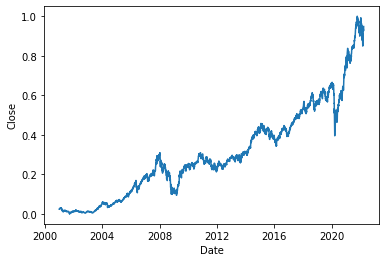

In [151]:
import seaborn as sns
sns.lineplot(x=data_sc.index, y='Close', data=data_sc)


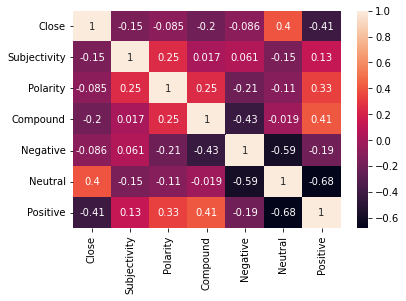

In [153]:
#co-relation
corr = data_sc.corr()
sns.heatmap(corr, annot=True)


# **LSTM**

In [178]:
# Import the necessary libraries
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
train_data, test_data = train_test_split(data_sc, train_size=0.8, shuffle=False)

# Define the model
model = Sequential()
model.add(LSTM(32, input_shape=(train_data.shape[1], 1), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))

In [179]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [180]:
# Reshape the data for input into the LSTM model
train_data = train_data.values.reshape((train_data.shape[0], train_data.shape[1], 1))
test_data = test_data.values.reshape((test_data.shape[0], test_data.shape[1], 1))

In [182]:
# Fit the model to the training data
history = model.fit(train_data, train_data[:,0], epochs=50, batch_size=32, validation_data=(test_data, test_data[:,0]))

Epoch 1/50
131/131 [==============================] - 4s 28ms/step - loss: 5.6937e-04 - val_loss: 8.9241e-04
Epoch 2/50
131/131 [==============================] - 3s 22ms/step - loss: 5.0655e-04 - val_loss: 0.0016
Epoch 3/50
131/131 [==============================] - 2s 14ms/step - loss: 5.3941e-04 - val_loss: 0.0046
Epoch 4/50
131/131 [==============================] - 1s 10ms/step - loss: 4.3496e-04 - val_loss: 0.0066
Epoch 5/50
131/131 [==============================] - 2s 13ms/step - loss: 4.0202e-04 - val_loss: 0.0088
Epoch 6/50
131/131 [==============================] - 2s 17ms/step - loss: 3.5680e-04 - val_loss: 0.0052
Epoch 7/50
131/131 [==============================] - 2s 16ms/step - loss: 3.1881e-04 - val_loss: 0.0099
Epoch 8/50
131/131 [==============================] - 2s 17ms/step - loss: 3.0292e-04 - val_loss: 0.0079
Epoch 9/50
131/131 [==============================] - 1s 10ms/step - loss: 2.7769e-04 - val_loss: 0.0182
Epoch 10/50
131/131 [==============================

In [183]:
# Make predictions on the test data
predictions = model.predict(test_data)

33/33 [==============================] - 1s 4ms/step


In [199]:
# Calculate the mean squared error of the predictions
mse = mean_squared_error(test_data[:,0], predictions)
print('Mean Squared Error:', mse)

Mean Squared Error: 0.00963754610887884


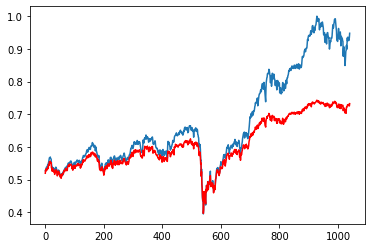

In [197]:
# Plot the predictions and the actual values
plt.plot(test_data[:,0])
plt.plot(predictions, color='red')
plt.show()


# **XGBOOST**

In [187]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [185]:
# Split the data into train and test sets
X = data_sc.drop(columns='Close')
y = data_sc['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [188]:
# XGBoost Model
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print("XGBoost MSE: ", mse_xgb)

[01:35:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost MSE:  0.016182161269241078


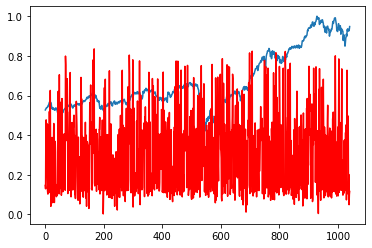

In [196]:
# Plot the predictions and the actual values
plt.plot(test_data[:,0])
plt.plot(y_pred_xgb, color='red')
plt.show()

# **RANDOM FOREST**

In [190]:
# Random Forest Model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Random Forest MSE: ", mse_rf)

Random Forest MSE:  0.01655043307574036


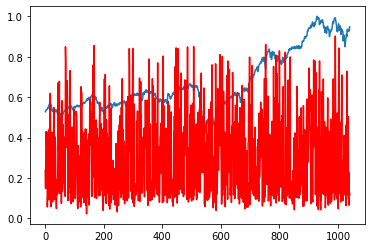

In [195]:
# Plot the predictions and the actual values
plt.plot(test_data[:,0])
plt.plot(y_pred_rf, color='red')
plt.show()

# **LSTM performs best in our data**

**LSTM model has the lowest mean squared error among the three models**

LSTM MSE= 0.00963754610887884  , XGBoost MSE:  0.016182161269241078 ,Random Forest MSE:  0.01655043307574036 